In [10]:
# Importing the data
import os
import numpy as np
import matplotlib.image as mpimg

path = "/Users/jacky/ImageGeneration/monet_jpg"
os.chdir(path)

# iterate through all file 
data  = []
for file in os.listdir(): 
    # Check whether file is in text format or not 
    if file.endswith(".jpg"): 
        file_path = f"{path}/{file}"
        # print(file_path)
        img = mpimg.imread(file_path)
        data.append(img)
        # call read text file function 





/var/folders/gj/xvj3czsn3h157hvszgtqt2mc0000gp/T/ipykernel_4607/1200664236.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(int(num_samples/cols) + 1, cols, i + 1)


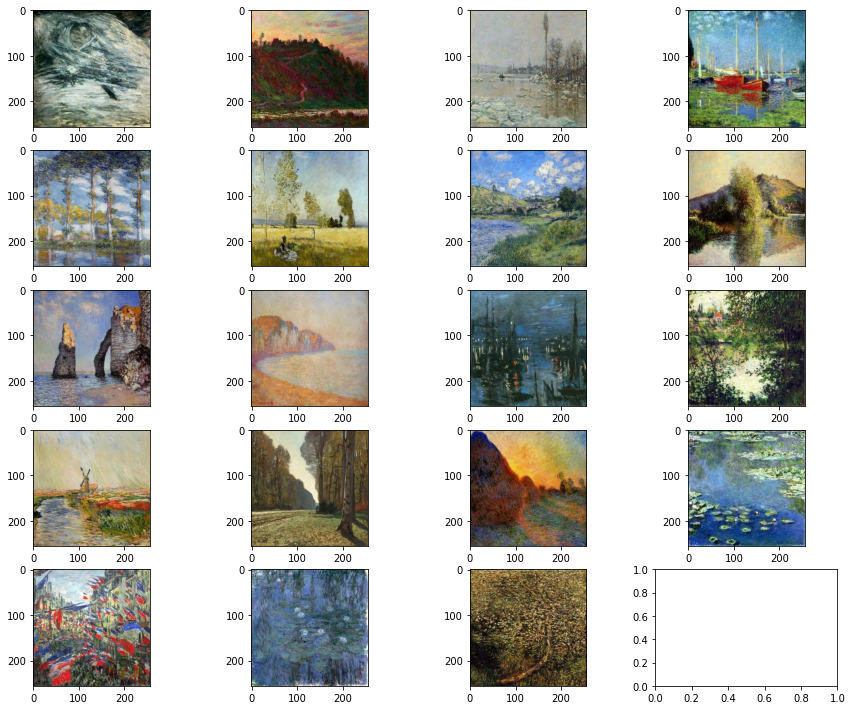

In [11]:
import torch
import torchvision
import matplotlib.pyplot as plt

def show_images(data, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15)) 
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.imshow(img)
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)

show_images(data)

In [12]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Pre-calculate different terms for closed form
T = 300
betas = linear_beta_schedule(timesteps=T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [13]:
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np
from MonetDataset import MonetDataset

IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)

    train = MonetDataset(root=".",transform=data_transform)
    return train
def show_tensor_image(image):
    
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

/var/folders/gj/xvj3czsn3h157hvszgtqt2mc0000gp/T/ipykernel_4607/1509478405.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


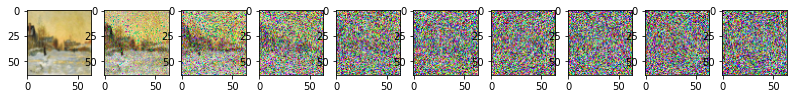

In [14]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

In [15]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.linear =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.linear(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 32

        # Time embedding
        self.linear = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        self.down1 = Block(64,128,32)
        self.down2 = Block(128,256,32)
        self.down3 = Block(256,512,32)
        self.down4 = Block(512,1024,32)

        self.up1 = Block(1024,512,32,up=True)
        self.up2 = Block(512,256,32,up=True)
        self.up3 = Block(256,128,32,up=True)
        self.up4 = Block(128,64,32,up=True)
        
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.linear(timestep)
        # Initial conv
        x1 = self.conv0(x)
        # Unet
        x2 = self.down1(x1, t)
        x3 = self.down2(x2, t)
        x4 = self.down3(x3, t)
        x5 = self.down4(x4, t)

        #   skipped connections here
        cat1 = torch.cat((x5, x5), dim=1)
        x = self.up1(cat1,t)
        cat2 = torch.cat((x, x4), dim=1)
        x = self.up2(cat2,t)
        cat3 = torch.cat((x, x3), dim=1)
        x = self.up3(cat3,t)
        cat4 = torch.cat((x, x2), dim=1)
        x = self.up4(cat4,t)

        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (linear): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down1): Block(
    (linear): Linear(in_features=32, out_features=128, bias=True)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (down2): Block(
    (linear): Linear(in_features=32, out_features=256, bias=True)
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (transform): Conv2d(256, 256, kernel_size=(4, 4), stride

In [16]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [17]:
@torch.no_grad()
def sample_timestep(x, t):

    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def  sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()            

Epoch 0 | step 000 Loss: 0.8094474673271179 


/var/folders/gj/xvj3czsn3h157hvszgtqt2mc0000gp/T/ipykernel_4607/634776569.py:37: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


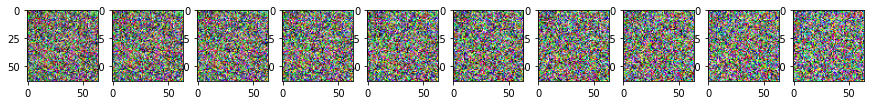

In [23]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 1 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()

In [24]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'checkpoint.pth')

In [25]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.optim import Adam

# # Load the checkpoint
# model = SimpleUnet()
# checkpoint = torch.load('/Users/jacky/ImageGeneration/checkpoint.pth')

# # Load the model state
# model.load_state_dict(checkpoint['model_state_dict'])
# device = "cuda" if torch.cuda.is_available() else "cpu"
# optimizer = Adam(model.parameters(), lr=0.001)

# # Load the optimizer state
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# # Retrieve other items like epoch and loss if needed
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# # Ensure the model is in evaluation mode
# model.eval()
# model.to(device)


/var/folders/gj/xvj3czsn3h157hvszgtqt2mc0000gp/T/ipykernel_4607/634776569.py:37: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


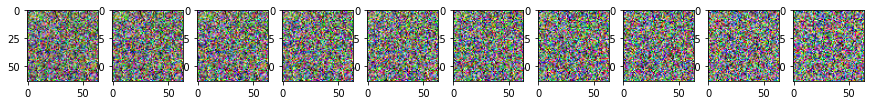

In [26]:
sample_plot_image()

In [27]:
print(t)
t.shape


tensor([181,  95, 251, 292, 106, 199, 127, 249,  96,  64,   3, 143, 275, 129,
        168,  64, 223, 215, 266,  28,  47, 228, 110, 241, 207,   4, 184, 133,
        177, 118, 174,  53,  54, 106, 177,  17, 186, 200, 219,  78, 190, 121,
        256,  67, 102,  91, 274, 247, 252,   7, 295, 104, 138, 175,  16, 177,
        213, 228, 123,  45,   6, 273, 152,  32, 193,  21, 228,  90, 292, 186,
        240, 271, 224, 200, 295, 294,  74, 240, 253,  64, 165, 237, 131,  32,
         62, 167,  43, 141,  79, 199,  88,  50,  13, 218, 239, 168,  85, 292,
        181, 120,  79,  48,  63,   0, 122, 151,  64, 112, 179, 153, 214, 259,
        188, 109,  58, 263, 162,  83, 179,  29,  72, 283, 147,  36, 113, 234,
        283, 276])


torch.Size([128])

/var/folders/gj/xvj3czsn3h157hvszgtqt2mc0000gp/T/ipykernel_4607/634776569.py:37: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


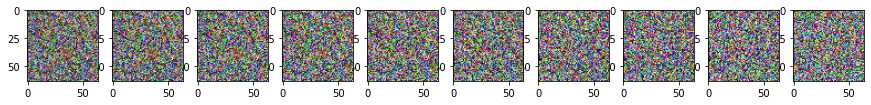

In [28]:
sample_plot_image()

/var/folders/gj/xvj3czsn3h157hvszgtqt2mc0000gp/T/ipykernel_4607/634776569.py:37: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


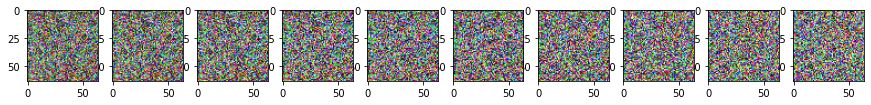

In [29]:
sample_plot_image()